$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/dror_tomer/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/dror_tomer/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/dror_tomer/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


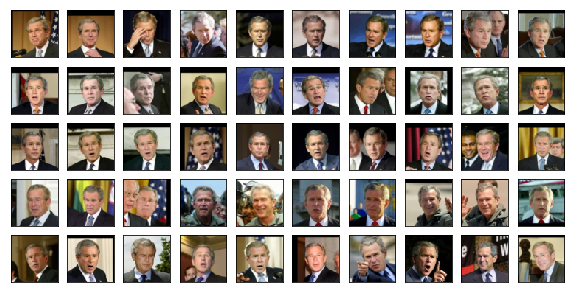

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (seq): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [10]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-5)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients.

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

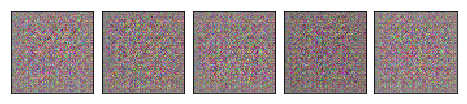

In [11]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [15]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002}}


--- EPOCH 1/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 1.091027518113454
Generator loss:     1.4505601988898382


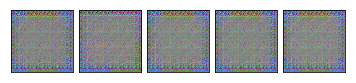

--- EPOCH 2/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.54it/s]
Discriminator loss: 0.499235772424274
Generator loss:     2.0231521924336753


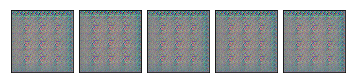

--- EPOCH 3/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.50it/s]
Discriminator loss: 0.32467354668511283
Generator loss:     2.7229064305623374


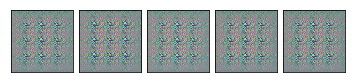

--- EPOCH 4/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 0.13777494471934107
Generator loss:     3.33806840578715


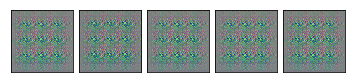

--- EPOCH 5/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 0.0881942090474897
Generator loss:     4.046187056435479


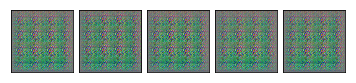

--- EPOCH 6/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.52it/s]
Discriminator loss: 0.12582426476809713
Generator loss:     4.402743975321452


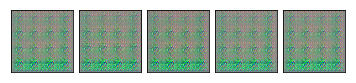

--- EPOCH 7/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
Discriminator loss: 0.21398665342066023
Generator loss:     3.4823415279388428


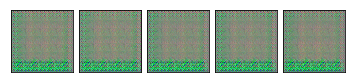

--- EPOCH 8/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
Discriminator loss: 0.11373006904290782
Generator loss:     4.1650405989752874


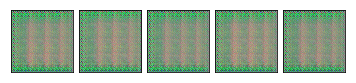

--- EPOCH 9/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 0.0922135247124566
Generator loss:     4.499154726664226


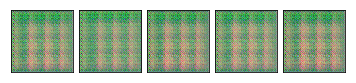

--- EPOCH 10/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.51it/s]
Discriminator loss: 0.10951253647605579
Generator loss:     4.607780403561062


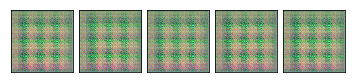

--- EPOCH 11/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.35it/s]
Discriminator loss: 0.04239973094728258
Generator loss:     4.516723844740126


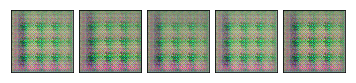

--- EPOCH 12/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 0.07788432679242557
Generator loss:     4.746607727474636


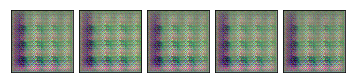

--- EPOCH 13/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.52it/s]
Discriminator loss: 0.1019182890239689
Generator loss:     5.214580800798204


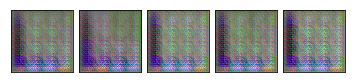

--- EPOCH 14/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 0.08162745667828454
Generator loss:     4.6461274358961315


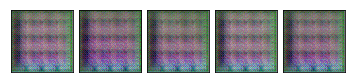

--- EPOCH 15/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
Discriminator loss: 0.052726805210113525
Generator loss:     4.951267189449734


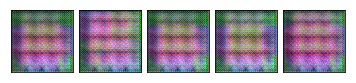

--- EPOCH 16/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.18it/s]
Discriminator loss: 0.0882653680940469
Generator loss:     5.131202750735813


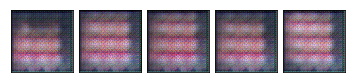

--- EPOCH 17/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.23it/s]
Discriminator loss: 0.1790163450770908
Generator loss:     4.654143942726983


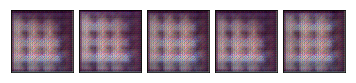

--- EPOCH 18/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
Discriminator loss: 0.09848668343491024
Generator loss:     4.460919698079427


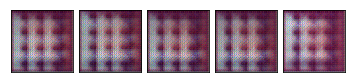

--- EPOCH 19/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 0.11280902143981722
Generator loss:     4.986906634436713


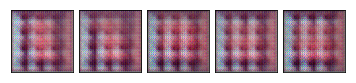

--- EPOCH 20/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
Discriminator loss: 0.09575611177004045
Generator loss:     5.006204764048259


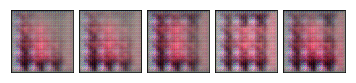

--- EPOCH 21/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 0.12092000970409976
Generator loss:     5.14446496963501


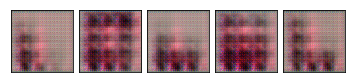

--- EPOCH 22/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 0.09865878522396088
Generator loss:     4.683324654897054


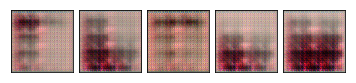

--- EPOCH 23/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.09176735083262126
Generator loss:     5.0965967708163795


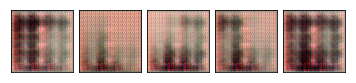

--- EPOCH 24/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 0.06124300758043925
Generator loss:     4.9098573260837135


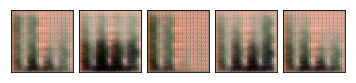

--- EPOCH 25/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
Discriminator loss: 0.11588148482971722
Generator loss:     5.127186722225613


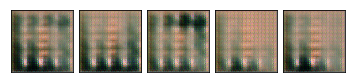

--- EPOCH 26/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.41it/s]
Discriminator loss: 0.040805639078219734
Generator loss:     5.08777035607232


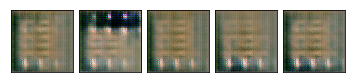

--- EPOCH 27/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 0.0849296400944392
Generator loss:     5.9302502208285865


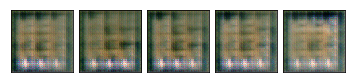

--- EPOCH 28/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.77it/s]
Discriminator loss: 0.06850473603440656
Generator loss:     5.645521534813775


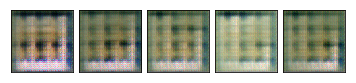

--- EPOCH 29/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 0.0690454085254007
Generator loss:     5.833399931589763


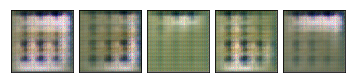

--- EPOCH 30/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 0.04203833101524247
Generator loss:     5.19786622789171


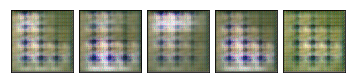

--- EPOCH 31/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.69it/s]
Discriminator loss: 0.10097239973644416
Generator loss:     5.520892408159044


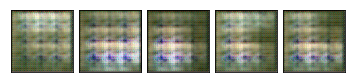

--- EPOCH 32/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
Discriminator loss: 0.06424011165897052
Generator loss:     5.09970940483941


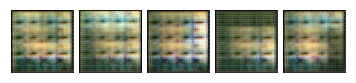

--- EPOCH 33/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.52it/s]
Discriminator loss: 0.08069691558678944
Generator loss:     5.061836136711968


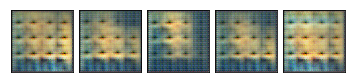

--- EPOCH 34/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.06101432359880871
Generator loss:     5.569449583689372


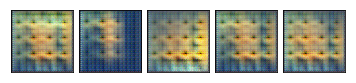

--- EPOCH 35/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 0.06921400957637364
Generator loss:     5.490089363521999


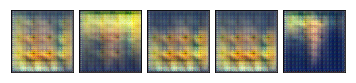

--- EPOCH 36/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 0.09348762366506788
Generator loss:     5.730275048149957


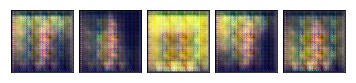

--- EPOCH 37/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.50it/s]
Discriminator loss: 0.1132957028845946
Generator loss:     5.427440643310547


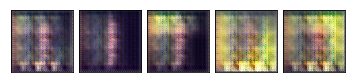

--- EPOCH 38/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.51it/s]
Discriminator loss: 0.107715695268578
Generator loss:     4.885285059611003


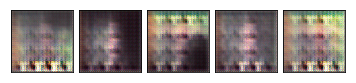

--- EPOCH 39/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.70it/s]
Discriminator loss: 0.12650977902942234
Generator loss:     4.578638288709852


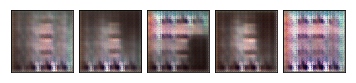

--- EPOCH 40/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
Discriminator loss: 0.20454194582998753
Generator loss:     4.77977540757921


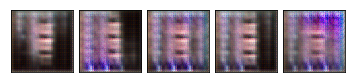

--- EPOCH 41/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.19it/s]
Discriminator loss: 0.1095341257750988
Generator loss:     4.706858476003011


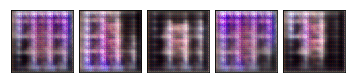

--- EPOCH 42/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
Discriminator loss: 0.060073624468512006
Generator loss:     4.8063635561201306


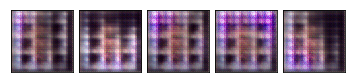

--- EPOCH 43/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 0.08486690330836508
Generator loss:     5.748438994089763


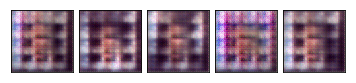

--- EPOCH 44/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.07it/s]
Discriminator loss: 0.14294212145937812
Generator loss:     5.239821910858154


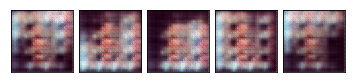

--- EPOCH 45/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: 0.16938775156935057
Generator loss:     4.704128000471327


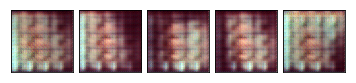

--- EPOCH 46/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 0.18267900248368582
Generator loss:     4.733643849690755


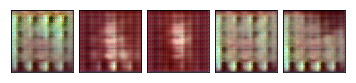

--- EPOCH 47/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.030253988587194018
Generator loss:     4.649974240197076


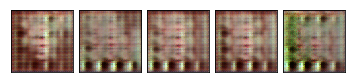

--- EPOCH 48/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.41it/s]
Discriminator loss: 0.12534760849343407
Generator loss:     5.6562586890326605


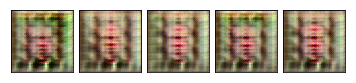

--- EPOCH 49/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
Discriminator loss: 0.14970608386728498
Generator loss:     5.134744326273601


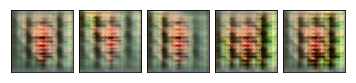

--- EPOCH 50/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
Discriminator loss: 0.03399838703787989
Generator loss:     5.732507228851318


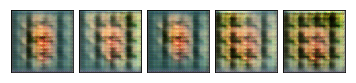

--- EPOCH 51/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
Discriminator loss: 0.1070683832383818
Generator loss:     6.283920500013563


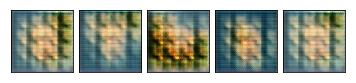

--- EPOCH 52/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.50it/s]
Discriminator loss: 0.058722794262899294
Generator loss:     6.06448867585924


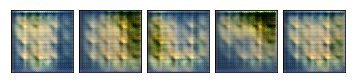

--- EPOCH 53/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.0714872930612829
Generator loss:     6.106249226464166


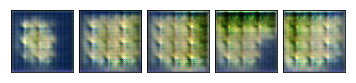

--- EPOCH 54/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
Discriminator loss: 0.09452436885072125
Generator loss:     5.242541207207574


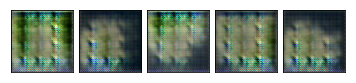

--- EPOCH 55/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.51it/s]
Discriminator loss: 0.11098691862490442
Generator loss:     4.776384459601508


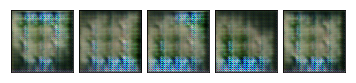

--- EPOCH 56/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.49it/s]
Discriminator loss: 0.08280209534698063
Generator loss:     5.215115547180176


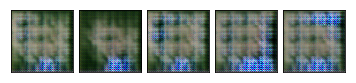

--- EPOCH 57/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
Discriminator loss: 0.12474787193867895
Generator loss:     5.272905084821913


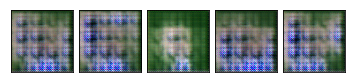

--- EPOCH 58/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.51it/s]
Discriminator loss: 0.04314783572529753
Generator loss:     5.431965668996175


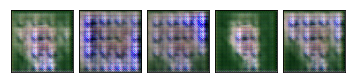

--- EPOCH 59/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: -0.005244706550406085
Generator loss:     5.472681098514133


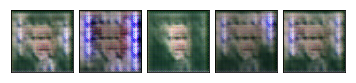

--- EPOCH 60/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.26it/s]
Discriminator loss: 0.09154234205683072
Generator loss:     5.640806886884901


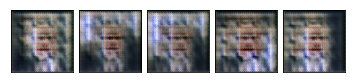

--- EPOCH 61/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.08380531105730268
Generator loss:     5.524836116366917


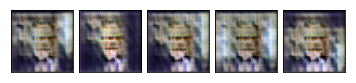

--- EPOCH 62/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
Discriminator loss: 0.04530892365922531
Generator loss:     5.797963407304552


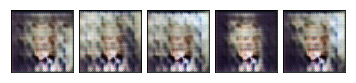

--- EPOCH 63/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.08140413711468379
Generator loss:     5.408572461869982


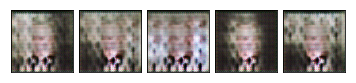

--- EPOCH 64/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.49it/s]
Discriminator loss: 0.2730196764071782
Generator loss:     5.813740915722317


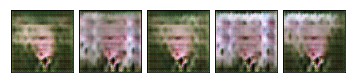

--- EPOCH 65/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 0.10146584361791611
Generator loss:     6.113131629096137


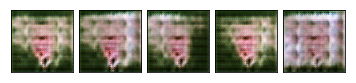

--- EPOCH 66/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
Discriminator loss: 0.07891326687402195
Generator loss:     5.989340570237902


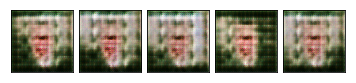

--- EPOCH 67/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
Discriminator loss: 0.11687166657712725
Generator loss:     6.507945378621419


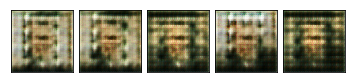

--- EPOCH 68/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 0.17968805424041218
Generator loss:     5.6817114882999


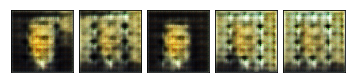

--- EPOCH 69/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.35it/s]
Discriminator loss: 0.09326885392268498
Generator loss:     5.086639881134033


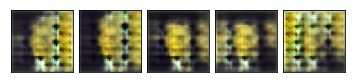

--- EPOCH 70/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.08293527530299293
Generator loss:     5.72356022728814


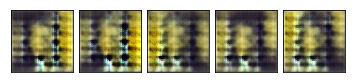

--- EPOCH 71/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.87it/s]
Discriminator loss: 0.09419954423275259
Generator loss:     5.820703082614475


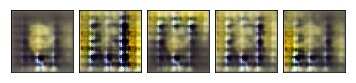

--- EPOCH 72/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.17it/s]
Discriminator loss: 0.019901991097463503
Generator loss:     6.506166723039415


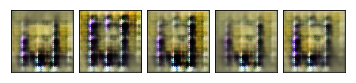

--- EPOCH 73/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 0.017951135834058125
Generator loss:     6.18754858440823


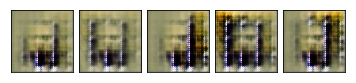

--- EPOCH 74/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
Discriminator loss: 0.07027306697434849
Generator loss:     6.5123425589667425


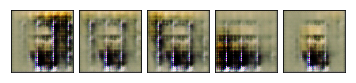

--- EPOCH 75/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.34it/s]
Discriminator loss: 0.04513645958569315
Generator loss:     6.1253922250535755


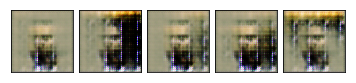

--- EPOCH 76/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
Discriminator loss: 0.12141161287824313
Generator loss:     6.011999077267117


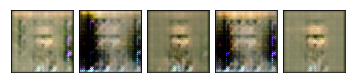

--- EPOCH 77/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.17005262192752627
Generator loss:     5.347760147518581


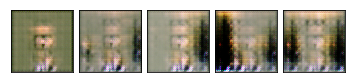

--- EPOCH 78/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
Discriminator loss: 0.08269594651129511
Generator loss:     5.1281642119089765


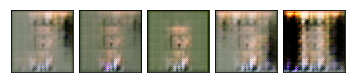

--- EPOCH 79/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
Discriminator loss: 0.05023590185576015
Generator loss:     5.348514874776204


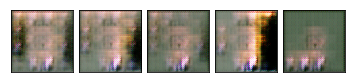

--- EPOCH 80/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 0.09550513616866535
Generator loss:     6.010866853925917


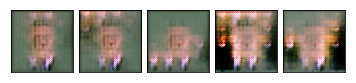

--- EPOCH 81/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
Discriminator loss: 0.058754606172442436
Generator loss:     6.192457728915745


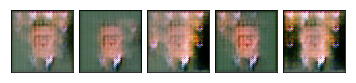

--- EPOCH 82/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.06994027727180058
Generator loss:     5.221273157331678


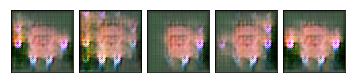

--- EPOCH 83/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.47it/s]
Discriminator loss: 0.16753697809245852
Generator loss:     5.228487385643853


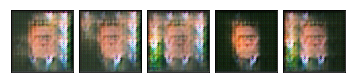

--- EPOCH 84/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.07349290160669221
Generator loss:     5.292221546173096


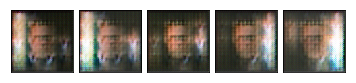

--- EPOCH 85/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.23it/s]
Discriminator loss: 0.10533850929803318
Generator loss:     5.111886342366536


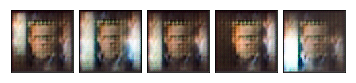

--- EPOCH 86/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 0.0786045098470317
Generator loss:     5.26314311557346


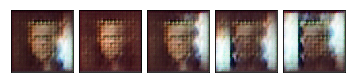

--- EPOCH 87/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
Discriminator loss: 0.14306369444562328
Generator loss:     5.478522300720215


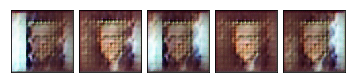

--- EPOCH 88/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
Discriminator loss: 0.06913249732719527
Generator loss:     5.316450383928087


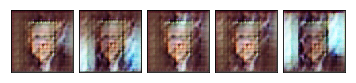

--- EPOCH 89/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 0.08040056708786222
Generator loss:     5.193337228563097


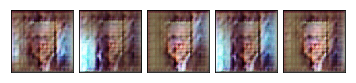

--- EPOCH 90/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.49it/s]
Discriminator loss: 0.11961692406071557
Generator loss:     5.2010261217753095


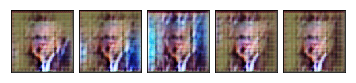

--- EPOCH 91/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.49it/s]
Discriminator loss: 0.12282989505264494
Generator loss:     5.472760253482395


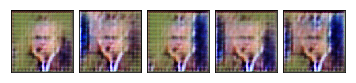

--- EPOCH 92/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.78it/s]
Discriminator loss: 0.08880557616551717
Generator loss:     5.07020812564426


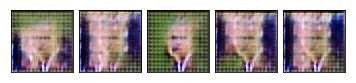

--- EPOCH 93/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
Discriminator loss: 0.08819310863812764
Generator loss:     5.45629162258572


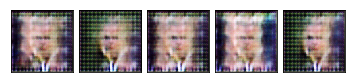

--- EPOCH 94/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
Discriminator loss: 0.09357209213905865
Generator loss:     5.229040622711182


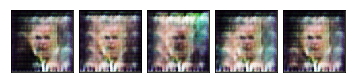

--- EPOCH 95/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.08939585907177793
Generator loss:     6.021822346581353


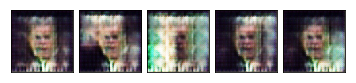

--- EPOCH 96/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
Discriminator loss: 0.08595153523816003
Generator loss:     5.7055984073215065


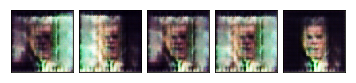

--- EPOCH 97/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.52it/s]
Discriminator loss: 0.08129263006978565
Generator loss:     5.740101125505236


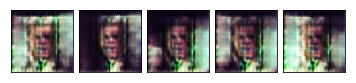

--- EPOCH 98/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 0.07410044388638602
Generator loss:     5.439244164360894


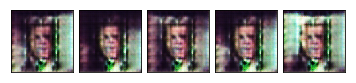

--- EPOCH 99/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
Discriminator loss: 0.10177015016476314
Generator loss:     5.520588397979736


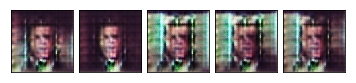

--- EPOCH 100/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.49it/s]
Discriminator loss: 0.08511905765367879
Generator loss:     5.617501205868191


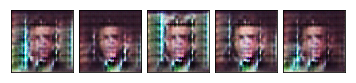

In [16]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


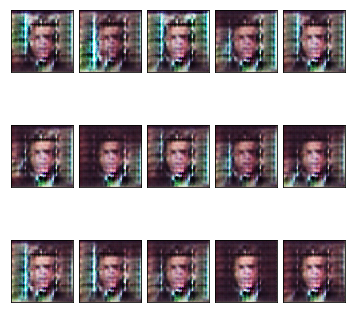

In [17]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [ ]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(hw3.answers.part3_q2)

### Question 2

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(hw3.answers.part3_q3)